# TEXT PROCESSING AND EXPLORATION

#### TEXT MINING AND SEARCH

*Master Degree in Data Science* <br>
*University of Milano-Bicocca* <br> <br>

 Marta Brasola, Andrea Malinverno, Mattia Proserpio


 In questo notebook facciamo tutto il processing e esplorazione del dataset --> output il dataset completamente processato che poi useremo come input per i task:
 - classificazione
 - topic modeling

In this notebook we are dealing with the processing and exploration task of the project. We will use the dataframe **song_processed** as the input for the 2 tasks:

1. Text Classification
2. Topic Modeling

STEPS
- Data Cleaning and Text normalization
  - regex
  - token
  - stopwords
  - lemmatizing

- exploration
  - calculating text statistics

- plots

- Rhyme analysis

- output the processed dataframe

In [ ]:
!pip install pronouncing
!pip install symspellpy

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
# from itertools import cycle
from tabulate import tabulate
import itertools


from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from symspellpy import SymSpell, Verbosity
import pkg_resources
import pronouncing
from pronouncing import rhymes

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [88]:
df = pd.read_csv('/content/drive/MyDrive/songs_final.csv')

In [89]:
df.drop(columns=['artist', 'views', 'features', 'id', 'language_cld3', 'language_ft', 'language'], inplace=True)

## Text Processing

In [90]:
df.columns = ['title', 'tag', 'year', 'raw_lyrics', 'decade']
df

title  tag  year  \
0               Rap God  rap  2013   
1                   WAP  rap  2020   
2          Shape of You  pop  2017   
3               HUMBLE.  rap  2017   
4             The Hills   rb  2015   
...                 ...  ...   ...   
3731        Bahama Mama  rap  1969   
3732               Fame  rap  1968   
3733  Mining On my Mind  rap  1969   
3734        Lead Single  rap  1963   
3735        Doin Things  rap  1969   

                                             raw_lyrics decade  
0     [Intro]\n"Look, I was gonna go easy on you not...  2010s  
1     [Intro: Cardi B, Al "T" McLaran & Megan Thee S...  2020s  
2     [Verse 1]\nThe club isn't the best place to fi...  2010s  
3     [Intro]\nNobody pray for me\nIt been that day ...  2010s  
4     [Intro]\nYeah\nYeah\nYeah\n\n[Verse 1]\nYour m...  2010s  
...                                                 ...    ...  
3731  Oh jd\nBack at it again\nFeels nice\nShes my b...  1960s  
3732  My mined is mine teasing I got a good reason t...  1960s  
3733  I ain't get to plant no wheat, ain't get to pu...  1960s  
3734  *inaudable noises*\\n\n\n\nYou can not underst...  1960s  
3735  Keeping you doing things\nLike watching TV, go...  1960s  

[3736 rows x 5 columns]

In [91]:
def clean_text(text):
    # remove punctuation
    text = re.sub(r'[,;\.!?-]', '', text)
    # removing text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # removing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # removing brackets
    text = re.sub(r'[()]', '', text)
    # remove forward slash
    text = text.replace('/', '')
    # remove asterisk
    text = text.replace('*', '')
    text = re.sub(r'"', '', text)
    text = re.sub(r"'", '', text)
    # replace '—' with an empty string
    text = text.replace('—', '')
    # convert all words to lowercase
    text = text.lower()
    return text

df['norm_lyrics'] = df['raw_lyrics'].apply(clean_text)

In [92]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

df['norm_lyrics'] = df['norm_lyrics'].replace('\n', '')
df['norm_lyrics'] = df['norm_lyrics'].apply(tokenize)

In [93]:
# Function to perform lemmatization and remove stop words
def lemmatize_and_remove_stopwords(tokens):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    stop_words.update(['oh', 'hey', 'ya', 'uh', 'huh', 'ooh', 'ah', 'yeah', 'na', 'yeah yeah'])

    # Perform lemmatization with pos_tag
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]

    # Remove stop words
    lemm_no_stop = [word for word in lemmatized if word.lower() not in stop_words]

    return lemm_no_stop

# Function to get WordNet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Noun

# Apply the lemmatize_and_remove_stopwords function to the 'norm_lyrics' column
df['lemm_no_stop'] = df['norm_lyrics'].apply(lemmatize_and_remove_stopwords)


In [94]:
def remove_stop_words(tokens):

    stop_words = set(stopwords.words('english'))
    stop_words.update(['oh', 'hey', 'ya', 'uh', 'huh', 'ooh', 'ah', 'yeah', 'na', 'yeah yeah'])
    no_stop = [word for word in tokens if word.lower() not in stop_words]
    return no_stop

In [95]:
df['no_stop'] = df['norm_lyrics'].apply(remove_stop_words)

## Text Exploration

In [96]:
# Function to calculate word statistics
def calculate_word_statistics(column):
    total_words = []
    unique_words = []

    for tokens in column:
        # Update total words count
        total_words.extend(tokens)

        # Update unique words count
        unique_words.extend(set(tokens))

    # Calculate statistics
    total_words_count = len(total_words)
    avg_words_per_song = total_words_count / len(column)

    unique_words_count = len(set(unique_words))
    avg_unique_words_per_song = unique_words_count / len(column)

    return total_words_count, avg_words_per_song, unique_words_count, avg_unique_words_per_song

# Calculate statistics for 'norm_lyrics' column
norm_lyrics_stats = calculate_word_statistics(df['norm_lyrics'])

# Calculate statistics for 'lemm_no_stop' column
lemm_no_stop_stats = calculate_word_statistics(df['lemm_no_stop'])

no_stop_stats = calculate_word_statistics(df['no_stop'])

In [97]:

table = [
    ["", "Total Words Count", "Avg Words per Song", "Unique Words Total", "Avg Unique Words per Song"],
    ["norm_lyrics", norm_lyrics_stats[0], norm_lyrics_stats[1], norm_lyrics_stats[2], norm_lyrics_stats[3]],
    ["lemm_no_stop", lemm_no_stop_stats[0], lemm_no_stop_stats[1], lemm_no_stop_stats[2], lemm_no_stop_stats[3]],
    ["no_stop", no_stop_stats[0], no_stop_stats[1], no_stop_stats[2], no_stop_stats[3]]
]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

╒══════════════╤═════════════════════╤══════════════════════╤══════════════════════╤═════════════════════════════╕
│              │   Total Words Count │   Avg Words per Song │   Unique Words Total │   Avg Unique Words per Song │
╞══════════════╪═════════════════════╪══════════════════════╪══════════════════════╪═════════════════════════════╡
│ norm_lyrics  │             1390924 │              372.303 │                31351 │                     8.3916  │
├──────────────┼─────────────────────┼──────────────────────┼──────────────────────┼─────────────────────────────┤
│ lemm_no_stop │              721297 │              193.067 │                26230 │                     7.02088 │
├──────────────┼─────────────────────┼──────────────────────┼──────────────────────┼─────────────────────────────┤
│ no_stop      │              724266 │              193.861 │                31193 │                     8.3493  │
╘══════════════╧═════════════════════╧══════════════════════╧═══════════════════

In [102]:
df['lemm_no_stop']

0       [look, gon, go, easy, hurt, feeling, im, go, g...
1       [whore, house, theres, whore, house, theres, w...
2       [club, isnt, best, place, find, lover, bar, go...
3       [nobody, pray, day, way, ayy, remember, syrup,...
4       [man, road, doin, promo, say, keep, business, ...
                              ...                        
3731    [jd, back, feels, nice, shes, bahama, mama, sh...
3732    [mine, mine, tease, get, good, reason, bend, b...
3733    [aint, get, plant, wheat, aint, get, punch, tr...
3734    [inaudable, noises\, understand, thesewords, w...
3735    [keep, thing, like, watch, tv, go, shop, liste...
Name: lemm_no_stop, Length: 3736, dtype: object

## Plots

### Plot TF-IDF in respect to labels

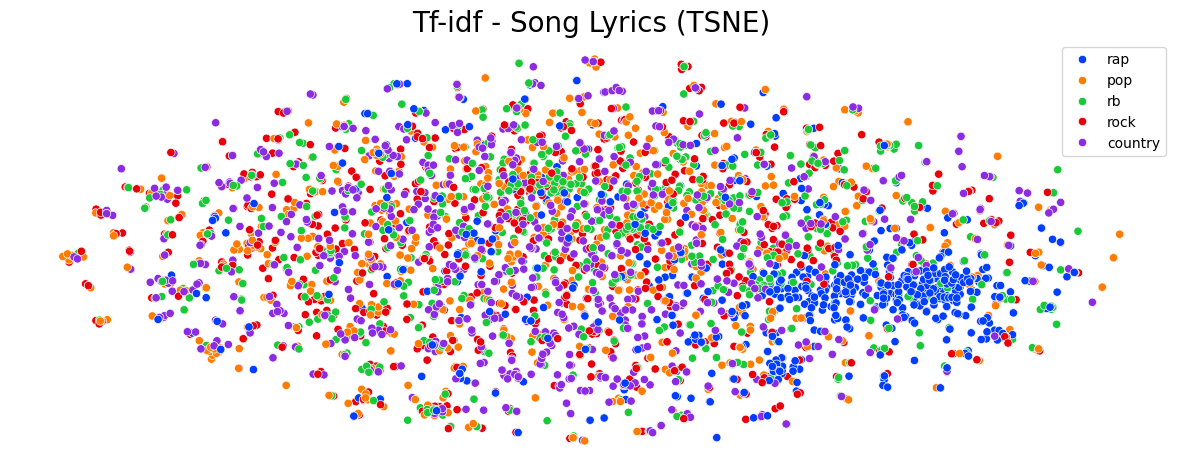

In [103]:
labels = df['tag'].values
tfidf_vectorizer = TfidfVectorizer(max_features=1200)
documents = [' '.join(words) for words in df['lemm_no_stop']]
tfidf = tfidf_vectorizer.fit_transform(documents)


# Plotting TF-IDF
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)

tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(tfidf.toarray())
scatter_x = data_tsne[:, 0]
scatter_y = data_tsne[:, 1]
sns.scatterplot(x=scatter_x, y=scatter_y, hue=labels, palette='bright', legend=True)
plt.title("Tf-idf - Song Lyrics (TSNE)", fontsize=20)
plt.axis('off')
plt.show()

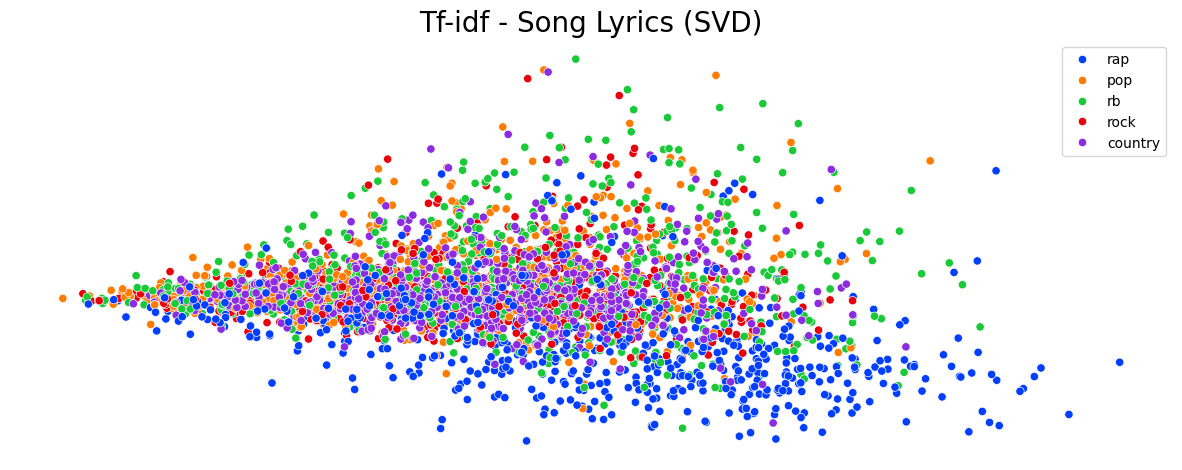

In [104]:
labels = df['tag'].values
tfidf_vectorizer = TfidfVectorizer(max_features=1200)
documents = [' '.join(words) for words in df['lemm_no_stop']]
tfidf = tfidf_vectorizer.fit_transform(documents)


# Plotting TF-IDF
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(tfidf)
scatter_x = data[:, 0]
scatter_y = data[:, 1]
sns.scatterplot(x=scatter_x, y=scatter_y, hue=labels, palette='bright', legend=True)
plt.title("Tf-idf - Song Lyrics (SVD)", fontsize=20)
plt.axis('off')
plt.show()

### World Cloud whole dataset

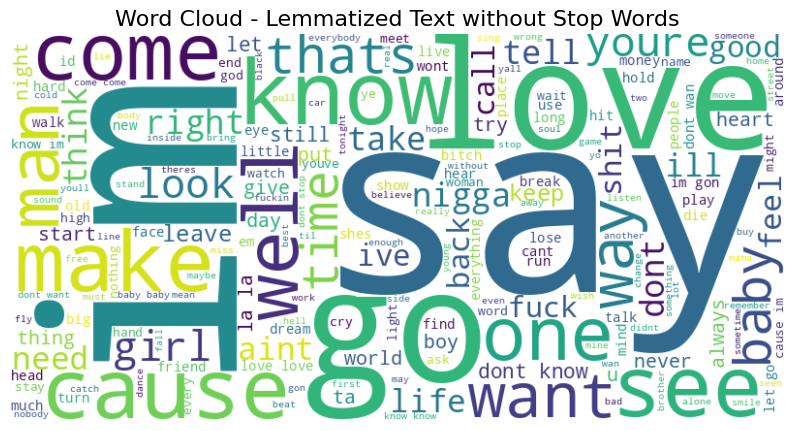

In [109]:
text = ' '.join(df['lemm_no_stop'].astype(str))
text = re.sub(r'[^a-zA-Z\s]', '', text)
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Lemmatized Text without Stop Words", fontsize=16)
plt.show()

### World Cloud based on music Genre

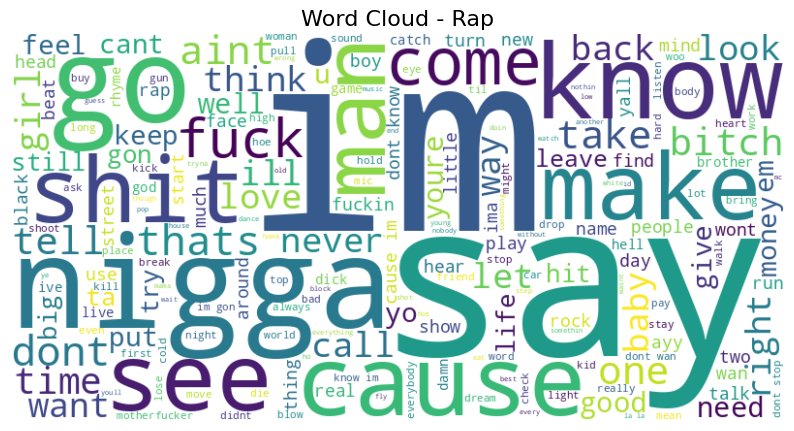

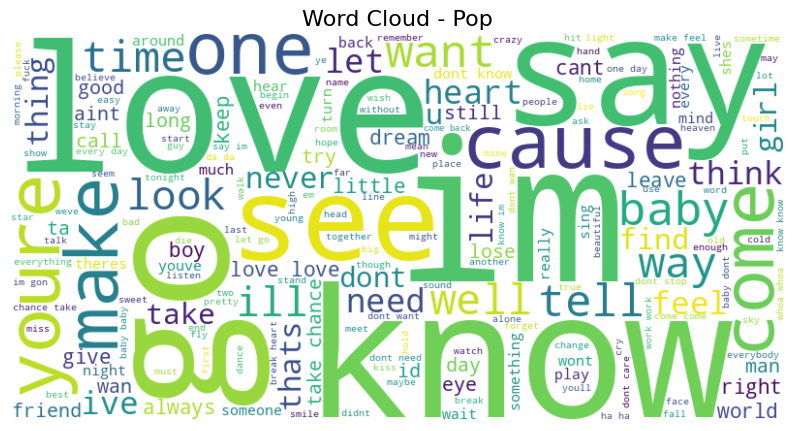

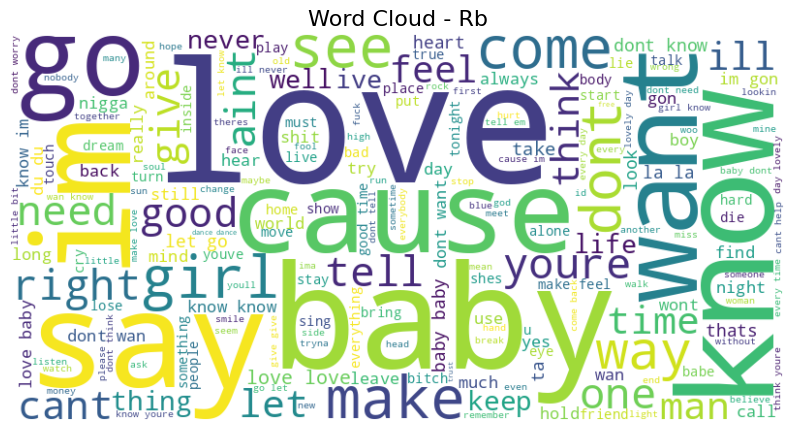

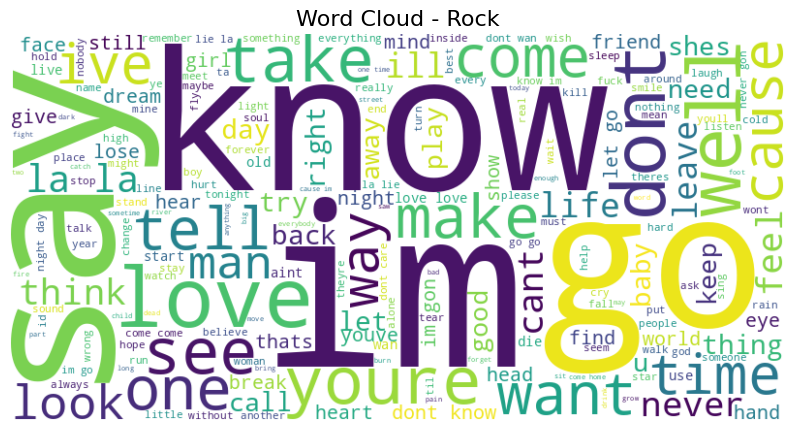

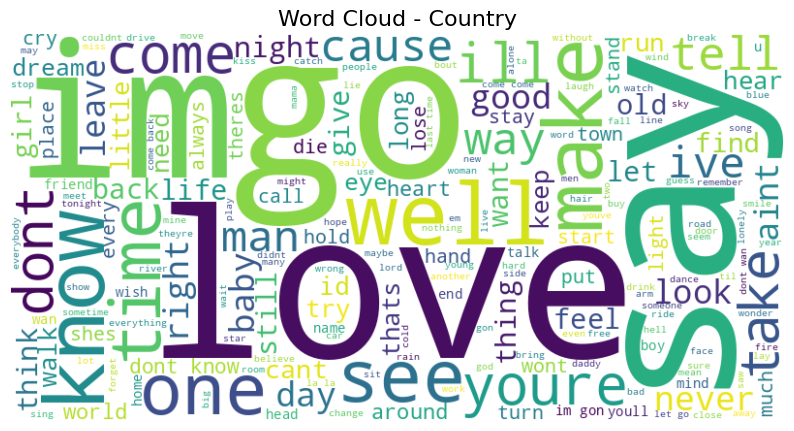

In [110]:
# Define the list of tags
tags = ['rap', 'pop', 'rb', 'rock', 'country']

# Generate a word cloud for each tag
for tag in tags:
    # Filter DataFrame for the specific tag
    subset_text = ' '.join(df[df['tag'] == tag]['lemm_no_stop'].astype(str))
    subset_text = re.sub(r'[^a-zA-Z\s]', '', subset_text)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(subset_text)

    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {tag.capitalize()}", fontsize=16)
    plt.show()

### Word Cloud for each decade

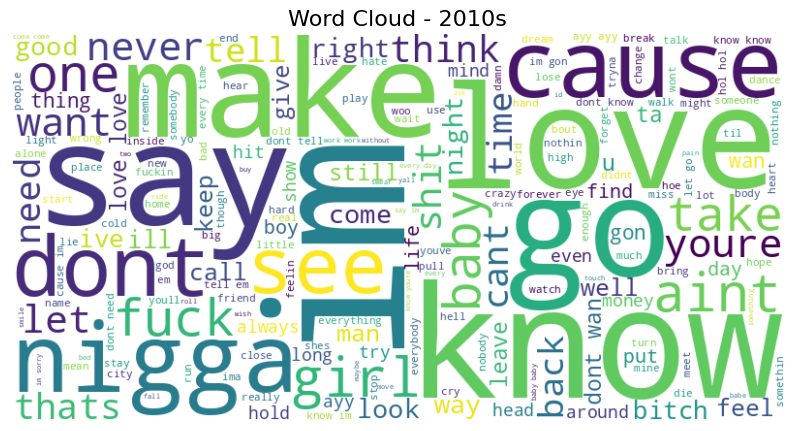

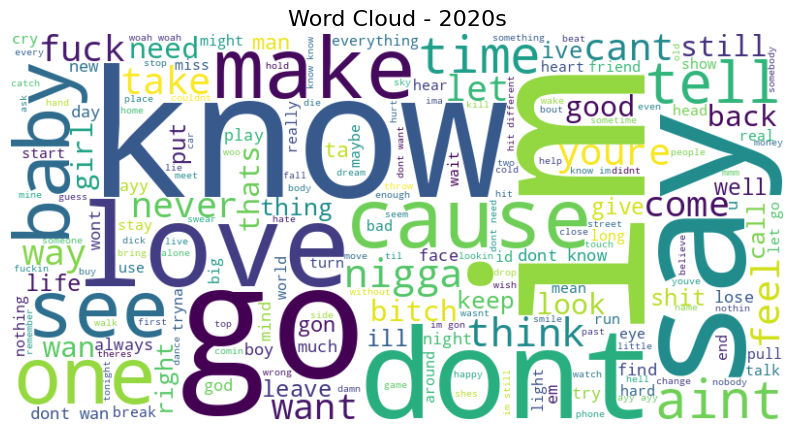

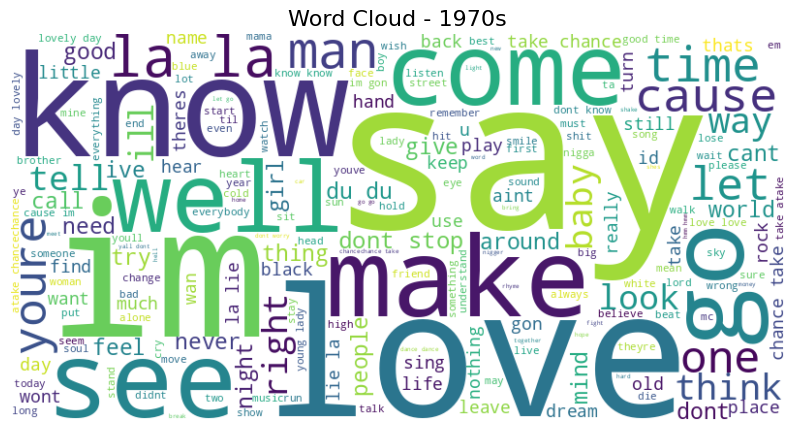

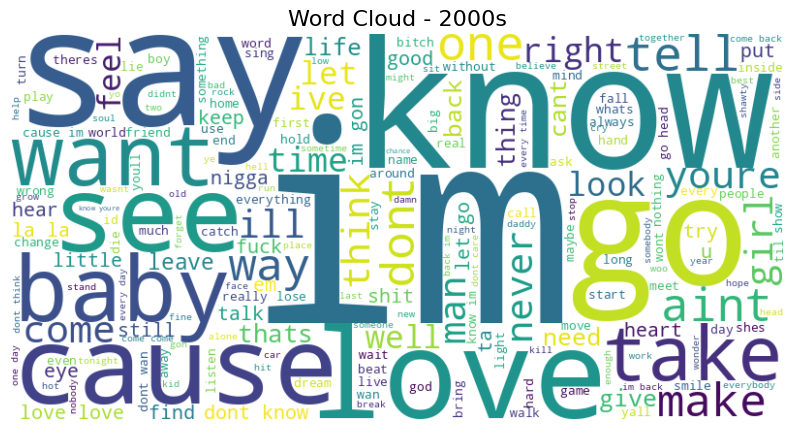

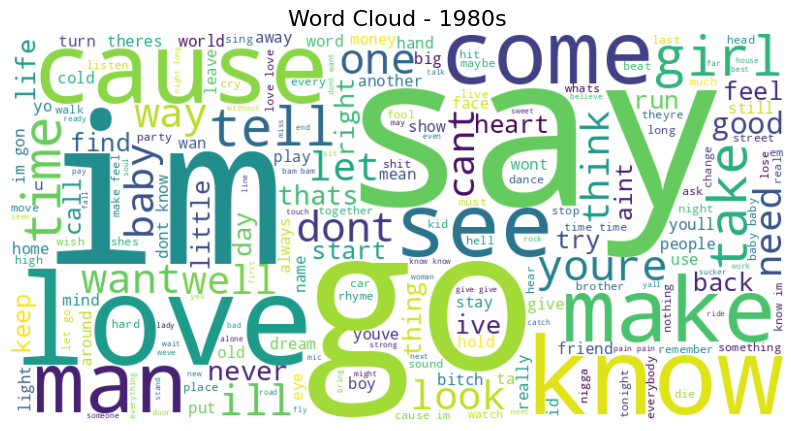

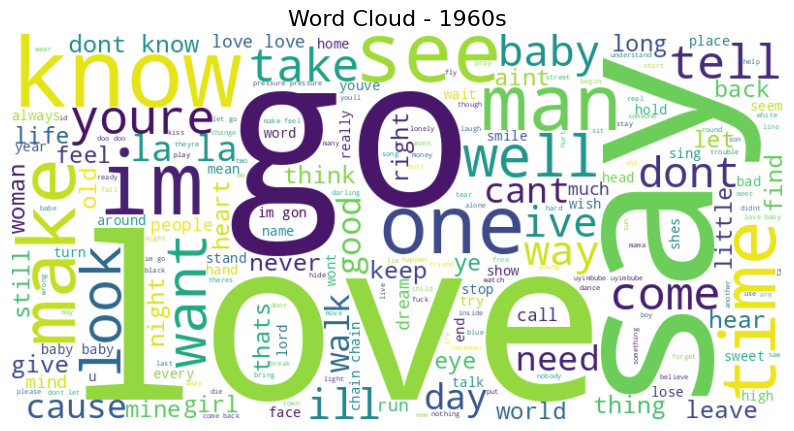

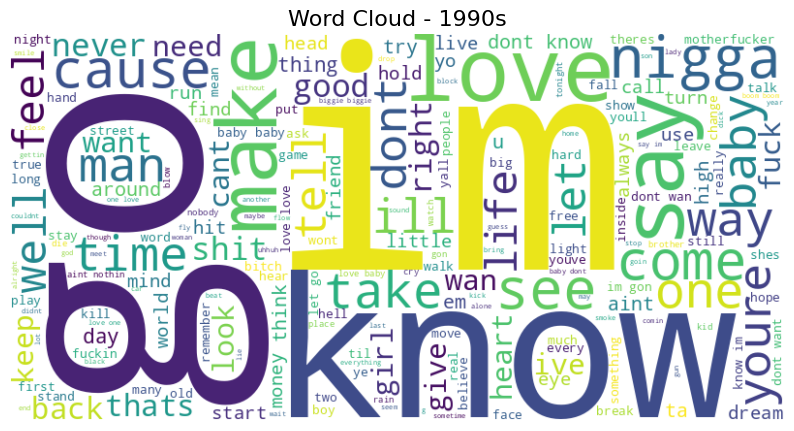

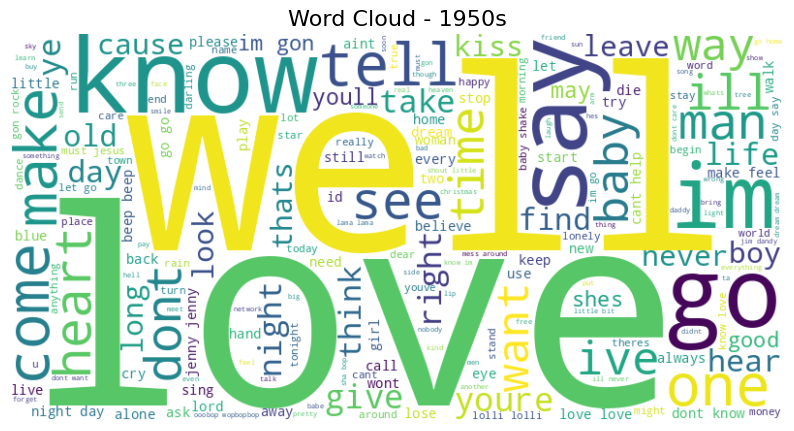

In [112]:
decades = ['2010s', '2020s', '1970s', '2000s', '1980s', '1960s', '1990s', '1950s']

# Generate a word cloud for each decade
for d in decades:
    # Filter DataFrame for the specific decade
    subset_text = ' '.join(df[df['decade'] == d]['lemm_no_stop'].astype(str))
    subset_text = re.sub(r'[^a-zA-Z\s]', '', subset_text)
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(subset_text)

    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {d}", fontsize=16)
    plt.show()

## Rhyme Analysis

In [113]:
# column that will be useful just for computing rhymes
df['rhyme_lyrics'] = df['raw_lyrics'].apply(clean_text)

In [114]:
sym_spell = SymSpell()
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, 0, 1)

def get_phones_and_syllables(lyrics):

  senteces = lyrics.split('\n')
  senteces = [line.strip() for line in senteces if line.strip() and line.strip() != '?']

  musical_lines = []

  for i in range(0, len(senteces)):
    musical_line = []

    tokens = word_tokenize(senteces[i])


    for word in tokens:
      phonemes = pronouncing.phones_for_word(word)
      if phonemes == []:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=1, include_unknown=True)
        for i in range(0, len(suggestions)):
          if phonemes:
            word = suggestions[i].term
            break

      if phonemes:
        tpl = (word, phonemes[0], pronouncing.syllable_count(phonemes[0]), pronouncing.stresses(phonemes[0]))
        musical_line.append(tpl)
      else:
        tpl = (word, 'UNK', -1, 'UNK')
        musical_line.append(tpl)

    musical_lines.append(musical_line)

  return musical_lines


def get_sublists(list, n):
  return [list[i:i+n] for i in range(len(list)-n+1)]


def check_rhyme(tpl1, tpl2):
  if tpl1[0] == tpl2[0]: return 1
  if tpl1[1] == 'UNK' or tpl2[1] == 'UNK': return 0

  rhyme = 0
  if tpl1[0] in pronouncing.rhymes(tpl2[0]): rhyme = 1
  elif tpl2[0] in pronouncing.rhymes(tpl1[0]): rhyme = 1

  return rhyme


#These functions detect for the presence of a particular 4 line rhyme scheme
def get_rhyme_ABAB(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[2]) and check_rhyme(quad_tpl[1],quad_tpl[3])

def get_rhyme_ABBA(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[3]) and check_rhyme(quad_tpl[1],quad_tpl[2])

def get_rhyme_AABB(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[1]) and check_rhyme(quad_tpl[2],quad_tpl[3])

def get_rhyme_ABAA(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[2]) and check_rhyme(quad_tpl[2],quad_tpl[3])

def get_rhyme_AABA(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[1]) and check_rhyme(quad_tpl[1],quad_tpl[3])


def get_rhyme_features(musical_data):

    last_words = []
    for line in musical_data:
       last_words.append(line[-1]) #we only care about last tuple of each line

    #Check frequency of rhyming adjacent couplets
    couplets = get_sublists(last_words, 2)
    couplet_rhymes = []
    for couplet in couplets:
        couplet_rhymes.append(check_rhyme(couplet[0], couplet[1]))

    adj_couplet_freq = sum(couplet_rhymes) / len(couplet_rhymes) if len(couplet_rhymes) != 0 else 0

    #Check frequency of rhyming spaced couplets
    triplets = get_sublists(last_words, 3)
    spaced_couplet_rhymes = []
    for triplet in triplets:
        spaced_couplet_rhymes.append(check_rhyme(triplet[0], triplet[2]))

    spaced_couplet_freq = sum(spaced_couplet_rhymes)/len(spaced_couplet_rhymes) if len(spaced_couplet_rhymes) != 0 else 0

    #check for presence of 4-line rhyme schemes and dbl space couplets
    abab, abba, aabb, abaa, aaba = 0,0,0,0,0
    quads = get_sublists(last_words, 4)
    dbl_spaced_couplet_rhymes = []

    for quad in quads:
        if get_rhyme_ABAB(quad): abab = 1
        if get_rhyme_ABBA(quad): abba = 1
        if get_rhyme_AABB(quad): aabb = 1
        if get_rhyme_ABAA(quad): abaa = 1
        if get_rhyme_AABA(quad): aaba = 1
        dbl_spaced_couplet_rhymes.append(check_rhyme(quad[0], quad[3]))

    dbl_spaced_freq = sum(dbl_spaced_couplet_rhymes)/len(dbl_spaced_couplet_rhymes) if len(dbl_spaced_couplet_rhymes) != 0 else 0

    #Lastly get total freq of pairwise rhymes
    rhyme_pairwise = []
    comb = itertools.combinations(last_words, 2)
    for pair in list(comb): rhyme_pairwise.append(check_rhyme(pair[0], pair[1]))
    pairwise_freq = sum(rhyme_pairwise)/len(rhyme_pairwise) if len(rhyme_pairwise) != 0 else 0

    return [
        adj_couplet_freq, spaced_couplet_freq, dbl_spaced_freq,
        abab, abba, aabb, abaa, aaba, pairwise_freq]


def get_musical_feature_vector(lyrics, rhyming=True, std_meters=True):

    musical_data = get_phones_and_syllables(lyrics)

    output = []
    if rhyming: output += get_rhyme_features(musical_data)
    return output


features_rhyme = np.array([get_musical_feature_vector(lyric) for lyric in df['rhyme_lyrics']])


data = pd.DataFrame(features_rhyme, columns =['adj_couplet_freq', 'spaced_couplet_freq', 'dbl_spaced_freq',
        'abab', 'abba', 'aabb', 'abaa', 'aaba', 'pairwise_freq'])

- adj_couplet_freq: This represents the frequency of adjacent rhyming couplets, where two consecutive lines in a poem rhyme with each other.

- spaced_couplet_freq: This indicates the frequency of spaced rhyming couplets, where the rhyming lines are not consecutive but are separated by one or more non-rhyming lines.

- dbl_spaced_freq: This variable represent the frequency of double-spaced rhyming couplets, where the rhyming lines are separated by two or more non-rhyming lines.

- abab, abba, aabb, abaa, aaba: These variables represent different rhyme schemes. For example:

  - abab: The pattern where the first and third lines rhyme with each other, and the second and fourth lines rhyme with each other.
  - abba: The pattern where the first and fourth lines rhyme with each other, and the second and third lines rhyme with each other.
aabb: The pattern where the first two lines rhyme with each other, and the last two lines rhyme with each other.
  - abaa: The pattern where the first and third lines rhyme with each other, and the second line rhymes with the fourth line.
  - aaba: The pattern where the first three lines follow a specific rhyme scheme, and the last line has a different rhyme.
- pairwise_freq: This variable indicates the frequency of rhyming pairs in general, without specifying a particular rhyme scheme. It could be a more generic measure of the occurrence of rhyming lines in pairs.

In [115]:
data.head()

adj_couplet_freq  spaced_couplet_freq  dbl_spaced_freq  abab  abba  \
0             0.128834             0.092593         0.074534   1.0   1.0   
1             0.283951             0.200000         0.164557   1.0   1.0   
2             0.266667             0.303371         0.170455   1.0   1.0   
3             0.424242             0.261538         0.328125   1.0   1.0   
4             0.206897             0.017544         0.017857   0.0   1.0   
...                ...                  ...              ...   ...   ...   
3731          0.043478             0.000000         0.000000   0.0   0.0   
3732          0.000000             0.000000         0.000000   0.0   0.0   
3733          0.359375             0.285714         0.193548   1.0   1.0   
3734          0.000000             0.000000         0.000000   0.0   0.0   
3735          0.100000             0.068966         0.000000   0.0   0.0   

      aabb  abaa  aaba  pairwise_freq  
0      1.0   1.0   1.0       0.011447  
1      1.0   1.0   1.0       0.051189  
2      1.0   1.0   1.0       0.113797  
3      1.0   1.0   1.0       0.138399  
4      1.0   0.0   0.0       0.067212  
...    ...   ...   ...            ...  
3731   0.0   0.0   0.0       0.025362  
3732   0.0   0.0   0.0       0.000000  
3733   1.0   1.0   1.0       0.142308  
3734   0.0   0.0   0.0       0.000000  
3735   0.0   0.0   0.0       0.049462  

[3736 rows x 9 columns]

In [132]:
df.drop(columns=['rhyme_lyrics'], inplace =True)
df2 = df.copy(deep=True)
df2 = pd.concat([df, data], axis=1)
df2.head()

title  tag  year  \
0               Rap God  rap  2013   
1                   WAP  rap  2020   
2          Shape of You  pop  2017   
3               HUMBLE.  rap  2017   
4             The Hills   rb  2015   
...                 ...  ...   ...   
3731        Bahama Mama  rap  1969   
3732               Fame  rap  1968   
3733  Mining On my Mind  rap  1969   
3734        Lead Single  rap  1963   
3735        Doin Things  rap  1969   

                                             raw_lyrics decade  \
0     [Intro]\n"Look, I was gonna go easy on you not...  2010s   
1     [Intro: Cardi B, Al "T" McLaran & Megan Thee S...  2020s   
2     [Verse 1]\nThe club isn't the best place to fi...  2010s   
3     [Intro]\nNobody pray for me\nIt been that day ...  2010s   
4     [Intro]\nYeah\nYeah\nYeah\n\n[Verse 1]\nYour m...  2010s   
...                                                 ...    ...   
3731  Oh jd\nBack at it again\nFeels nice\nShes my b...  1960s   
3732  My mined is mine teasing I got a good reason t...  1960s   
3733  I ain't get to plant no wheat, ain't get to pu...  1960s   
3734  *inaudable noises*\\n\n\n\nYou can not underst...  1960s   
3735  Keeping you doing things\nLike watching TV, go...  1960s   

                                            norm_lyrics  \
0     [look, i, was, gon, na, go, easy, on, you, not...   
1     [whores, in, this, house, theres, some, whores...   
2     [the, club, isnt, the, best, place, to, find, ...   
3     [nobody, pray, for, me, it, been, that, day, f...   
4     [yeah, yeah, yeah, your, man, on, the, road, h...   
...                                                 ...   
3731  [oh, jd, back, at, it, again, feels, nice, she...   
3732  [my, mined, is, mine, teasing, i, got, a, good...   
3733  [i, aint, get, to, plant, no, wheat, aint, get...   
3734  [inaudable, noises\, you, can, not, understand...   
3735  [keeping, you, doing, things, like, watching, ...   

                                           lemm_no_stop  \
0     [look, gon, go, easy, hurt, feeling, im, go, g...   
1     [whore, house, theres, whore, house, theres, w...   
2     [club, isnt, best, place, find, lover, bar, go...   
3     [nobody, pray, day, way, ayy, remember, syrup,...   
4     [man, road, doin, promo, say, keep, business, ...   
...                                                 ...   
3731  [jd, back, feels, nice, shes, bahama, mama, sh...   
3732  [mine, mine, tease, get, good, reason, bend, b...   
3733  [aint, get, plant, wheat, aint, get, punch, tr...   
3734  [inaudable, noises\, understand, thesewords, w...   
3735  [keep, thing, like, watch, tv, go, shop, liste...   

                                                no_stop  adj_couplet_freq  \
0     [look, gon, go, easy, hurt, feelings, im, goin...          0.128834   
1     [whores, house, theres, whores, house, theres,...          0.283951   
2     [club, isnt, best, place, find, lover, bar, go...          0.266667   
3     [nobody, pray, day, way, ayy, remember, syrup,...          0.424242   
4     [man, road, doin, promo, said, keep, business,...          0.206897   
...                                                 ...               ...   
3731  [jd, back, feels, nice, shes, bahama, mama, sh...          0.043478   
3732  [mined, mine, teasing, got, good, reason, bend...          0.000000   
3733  [aint, get, plant, wheat, aint, get, punch, tr...          0.359375   
3734  [inaudable, noises\, understand, thesewords, w...          0.000000   
3735  [keeping, things, like, watching, tv, going, s...          0.100000   

      spaced_couplet_freq  dbl_spaced_freq  abab  abba  aabb  abaa  aaba  \
0                0.092593         0.074534   1.0   1.0   1.0   1.0   1.0   
1                0.200000         0.164557   1.0   1.0   1.0   1.0   1.0   
2                0.303371         0.170455   1.0   1.0   1.0   1.0   1.0   
3                0.261538         0.328125   1.0   1.0   1.0   1.0   1.0   
4                0.017544         0.017857   

### How many Songs do not have any rhymes? Which genre?

In [133]:
rhyme_cols = ['adj_couplet_freq',	'spaced_couplet_freq',	'dbl_spaced_freq',	'abab',	'abba',	'aabb',	'abaa',	'aaba',	'pairwise_freq']
df2 = df2.replace(0, np.nan)

In [135]:
df2[rhyme_cols].isnull().sum()

adj_couplet_freq        273
spaced_couplet_freq     359
dbl_spaced_freq         774
abab                   1761
abba                   1959
aabb                   1529
abaa                   1848
aaba                   1864
pairwise_freq            12
dtype: int64

In [137]:
df2.groupby('tag')[rhyme_cols].apply(lambda group: group.isnull().sum())

adj_couplet_freq  spaced_couplet_freq  dbl_spaced_freq  abab  abba  \
tag                                                                           
country               100                  133              248   483   503   
pop                    54                   62              144   353   414   
rap                    26                   62              110   272   290   
rb                     34                   36               97   324   352   
rock                   59                   66              175   329   400   

         aabb  abaa  aaba  pairwise_freq  
tag                                       
country   408   520   526              0  
pop       346   394   395              2  
rap       164   244   253              9  
rb        272   317   315              0  
rock      339   373   375              1

In [138]:
df2.fillna(0, inplace=True)

### Correlation between Rhyme metrics

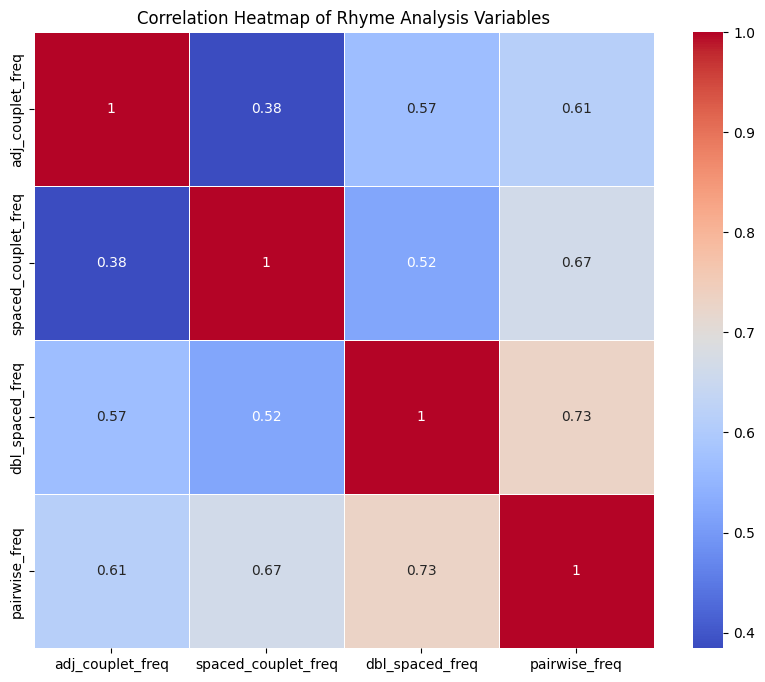

In [139]:
columns_to_plot = ['adj_couplet_freq', 'spaced_couplet_freq', 'dbl_spaced_freq', 'pairwise_freq']
subset_df = df2[columns_to_plot]
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(subset_df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Rhyme Analysis Variables')
plt.show()

In [141]:
df2.groupby('tag')[rhyme_cols].mean()

adj_couplet_freq  spaced_couplet_freq  dbl_spaced_freq      abab  \
tag                                                                         
country          0.166383             0.134026         0.071569  0.365309   
pop              0.181279             0.161839         0.098410  0.541558   
rap              0.180166             0.117380         0.074760  0.593423   
rb               0.196682             0.175711         0.118213  0.574244   
rock             0.199553             0.180452         0.102822  0.575484   

             abba      aabb      abaa      aaba  pairwise_freq  
tag                                                             
country  0.339028  0.463863  0.316689  0.308804       0.100349  
pop      0.462338  0.550649  0.488312  0.487013       0.105250  
rap      0.566517  0.754858  0.635277  0.621824       0.055834  
rb       0.537451  0.642576  0.583443  0.586071       0.113288  
rock     0.483871  0.562581  0.518710  0.516129       0.110977

In [142]:
df2.groupby('tag')[rhyme_cols].median()


adj_couplet_freq  spaced_couplet_freq  dbl_spaced_freq  abab  abba  \
tag                                                                           
country          0.131579             0.105263         0.040000   0.0   0.0   
pop              0.148148             0.134875         0.072949   1.0   0.0   
rap              0.162602             0.094340         0.051724   1.0   1.0   
rb               0.172414             0.152542         0.090909   1.0   1.0   
rock             0.175000             0.156250         0.068182   1.0   0.0   

         aabb  abaa  aaba  pairwise_freq  
tag                                       
country   0.0   0.0   0.0       0.076667  
pop       1.0   0.0   0.0       0.085945  
rap       1.0   1.0   1.0       0.041610  
rb        1.0   1.0   1.0       0.091503  
rock      1.0   1.0   1.0       0.086207

In [144]:
d# f2.to_csv('/content/drive/MyDrive/songs_processed.csv', index=False)